# Auto Encoder

## Load Dataset

In [1]:
DATASET_NAME = 'dataset-5000'
TEST_DATASET_NAME = 'dataset-test'
BATCH_SIZE = 16
MODEL_PATH = 'model/cnn'

import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms

from torch.utils.data import DataLoader
from util import GeneratedDataset

trainset = GeneratedDataset(DATASET_NAME, transforms.ToTensor())
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)

testset = GeneratedDataset(TEST_DATASET_NAME, transforms.ToTensor())
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'

if not os.path.exists(MODEL_PATH):
    os.makedirs(MODEL_PATH)

## Define CNN based auto-encoder

- 64 * 64 * 3 image input = 12,288
- Cov3 with 32 channel, 3 * 3 * 3 * 32 = 864 parameters
- ReLU
- MaxPool -> 32 * 32 * 32 hidden state = 32768
- Cov3 with 64 channel, 32 * 3 * 3 * 64 = 18432 parameters
- ReLU
- MaxPool -> 16 * 16 * 64 hidden state = 16384
- Cov3 with 128 channel, 64 * 3 * 3 * 128 = 73728 parameters
- ReLU
- MaxPool -> 8 * 8 * 128 = 8192 hidden state
- Full connected 8192 -> **embedding size**

And the decoder works reversely.

In [2]:
# Define the autoencoder model
class Autoencoder(nn.Module):
    def __init__(self, embedding_size=32):
        super(Autoencoder, self).__init__()
        self.embedding_size = embedding_size
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2)
        )
        self.fc1 = nn.Linear(8 * 8 * 128, self.embedding_size)  # Fully connected layer to get 32-length embedding

        # Decoder
        self.fc2 = nn.Linear(self.embedding_size, 8 * 8 * 128)  # Fully connected layer to reshape back to 8x8x128
        self.decoder = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(32, 3, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        encoded = encoded.view(encoded.size(0), -1)  # Flatten the tensor
        encoded = self.fc1(encoded)  # Get the embedding
        decoded = self.fc2(encoded)  # Reshape back to 8x8x128
        decoded = decoded.view(decoded.size(0), 128, 8, 8)
        decoded = self.decoder(decoded)
        return decoded, encoded

In [3]:
from util import calc_and_plot_metrics, fit_nearest_neighbor, train_model_steps, plot_model, count_parameters, save_to_file, load_from_file

accuracy = {}

def train_model(embedding_size=32, learning_rate=1e-4, weight_decay=1e-5, num_epochs=20):
    # Initialize the model
    model = Autoencoder(embedding_size=embedding_size)
    print(f'Number of parameters: {count_parameters(model)}')

    model_path = f'{MODEL_PATH}/e{embedding_size}.pth'
    stat_path = f'{MODEL_PATH}/e{embedding_size}.pkl'
    if os.path.exists(model_path) and os.path.exists(stat_path):
        model.load_state_dict(torch.load(model_path))
        model = model.to(device)
        train_losses, test_losses = load_from_file(stat_path)
    else:
        model, train_losses, test_losses = train_model_steps(model, trainloader, testloader, learning_rate, weight_decay, num_epochs)
        # Save the model
        torch.save(model.state_dict(), model_path)
        save_to_file((train_losses, test_losses), stat_path)

    acc = fit_nearest_neighbor(model)
    accuracy[embedding_size] = acc
    calc_and_plot_metrics(model, testset)
    plot_model(model, train_losses, test_losses, testset)
    return model, train_losses, test_losses

## Evaluation

Testing with embedding size of (down from 8192)
- 4
- 8
- 16
- 32
- 64

Number of parameters: 407687


/Users/criyle/project/cse5524/cse5524final/util.py:333: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_embeddings = torch.tensor(train_embeddings)
/Users/criyle/project/cse5524/cse5524final/util.py:334: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_embeddings = torch.tensor(test_embeddings)


Color Accuracy: 0.212
Shape Accuracy: 0.724
Combined Accuracy: 0.15


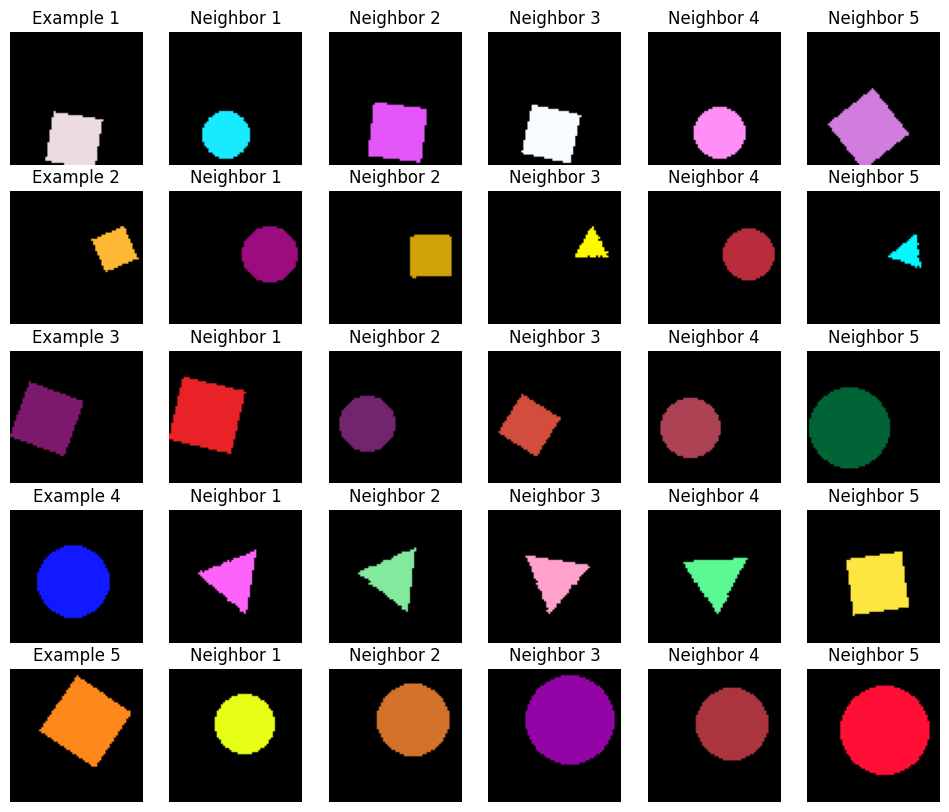

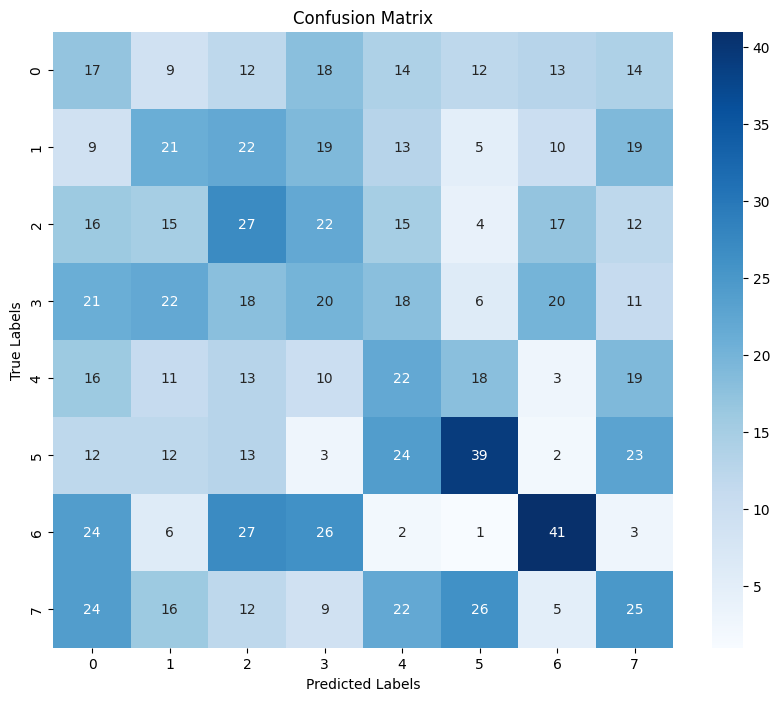

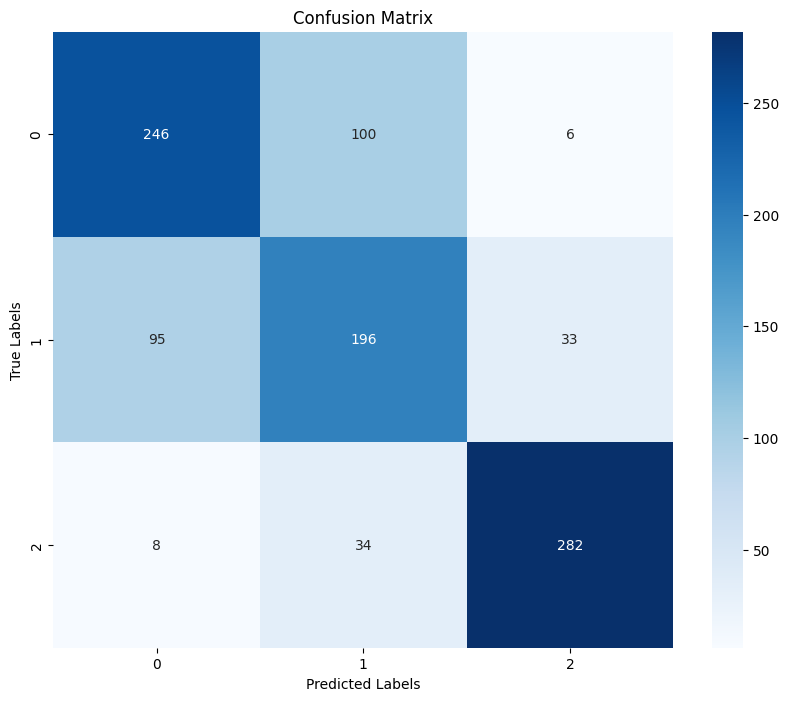

Silhouette Score: -0.19565542042255402
Cluster Purity: 0.183
Normalized Mutual Information (NMI): 0.24182659583780233


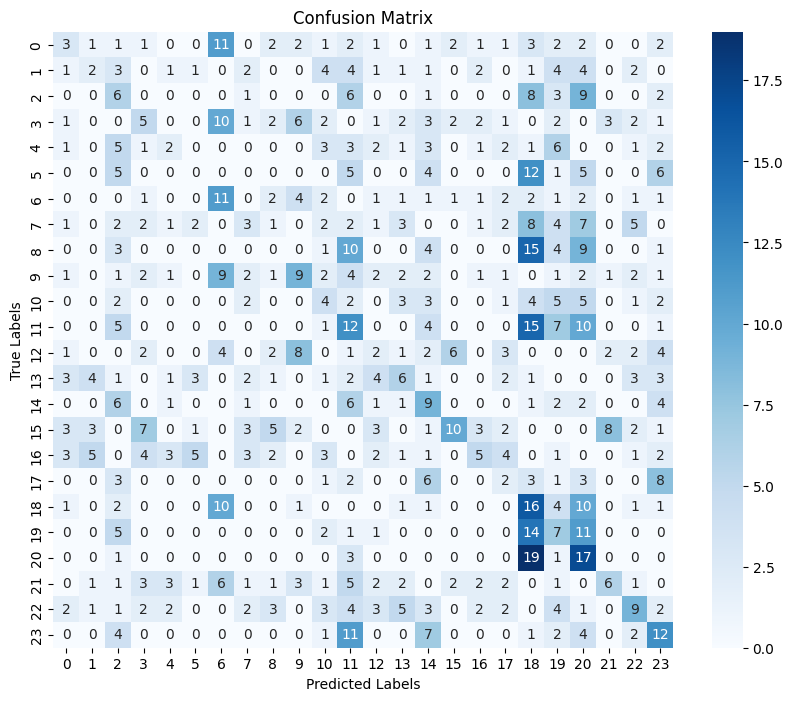

Silhouette Score: -0.1261436492204666
Cluster Purity: 0.236
Normalized Mutual Information (NMI): 0.07062677042534517


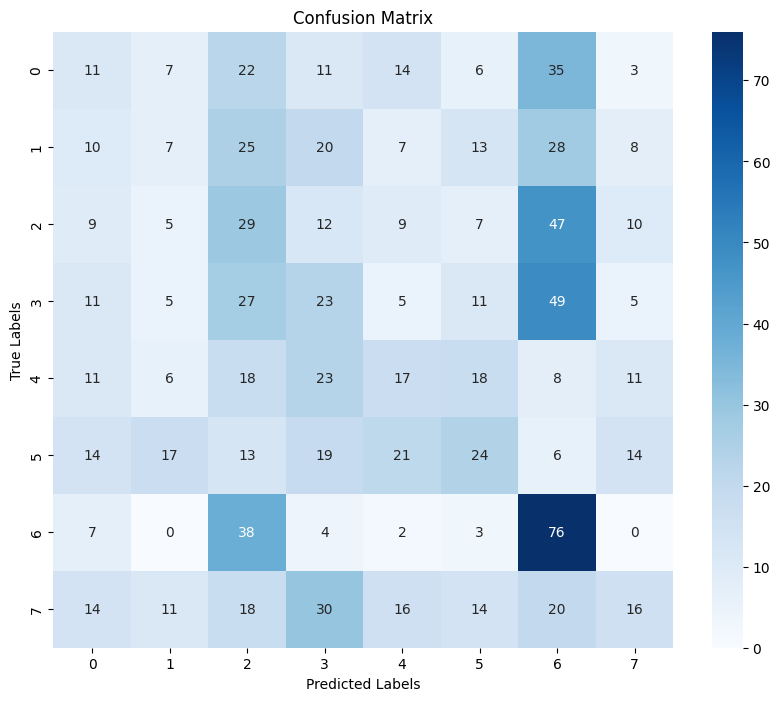

Silhouette Score: 0.023942304775118828
Cluster Purity: 0.465
Normalized Mutual Information (NMI): 0.12073548933239049


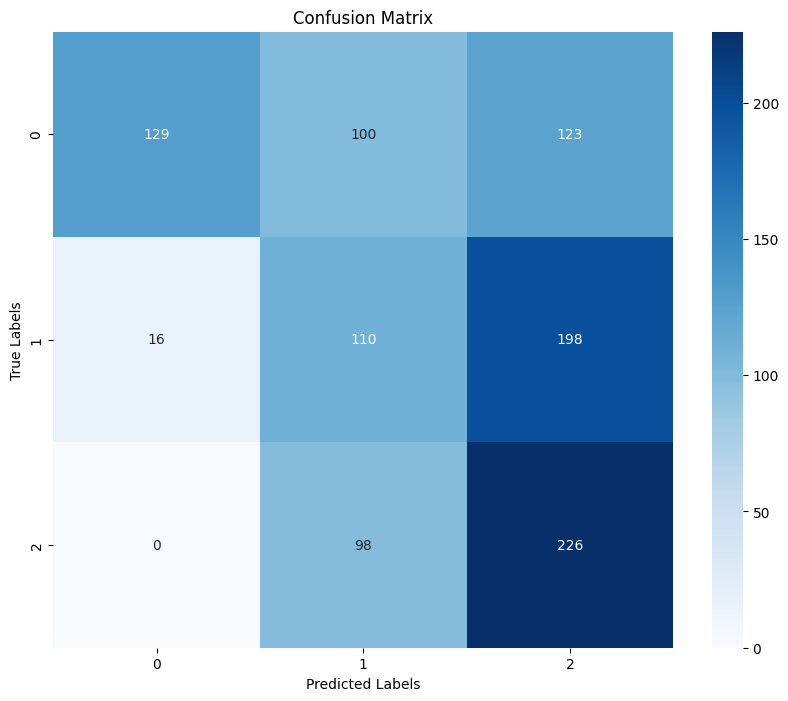

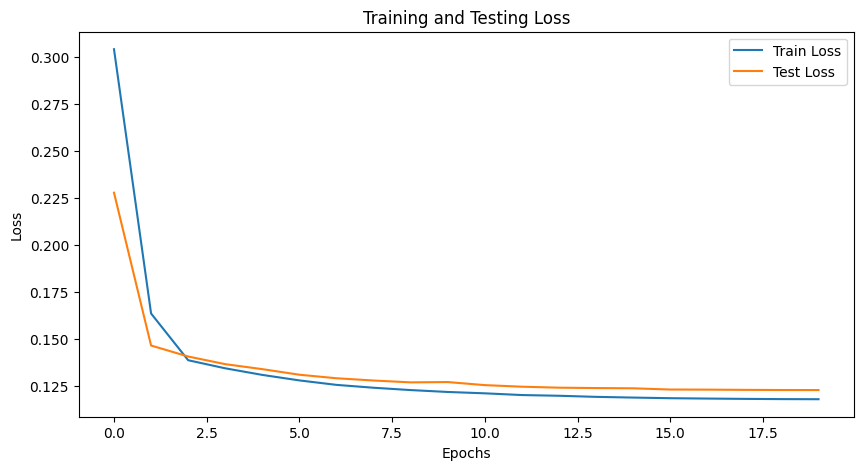

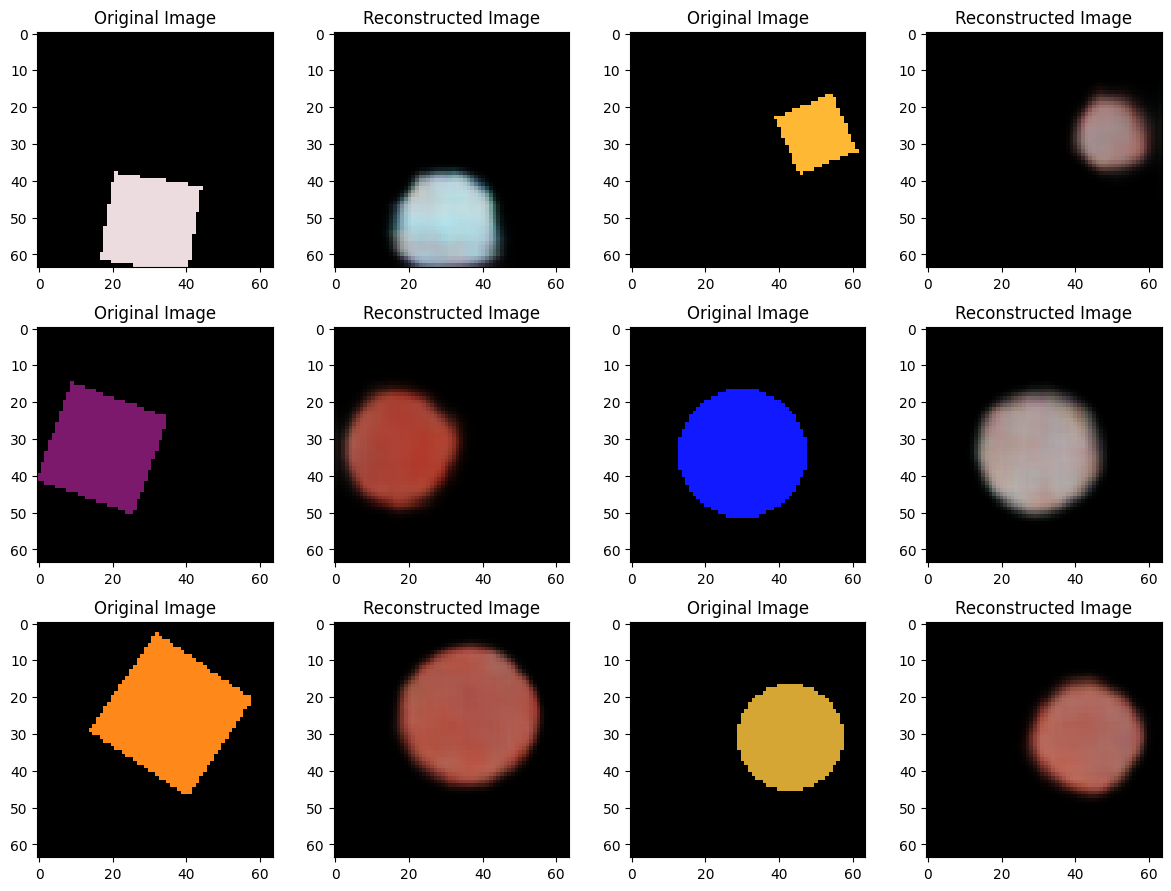

(Autoencoder(
   (encoder): Sequential(
     (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU()
     (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (4): ReLU()
     (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (7): ReLU()
     (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   )
   (fc1): Linear(in_features=8192, out_features=4, bias=True)
   (fc2): Linear(in_features=4, out_features=8192, bias=True)
   (decoder): Sequential(
     (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU()
     (2): Upsample(scale_factor=2.0, mode='nearest')
     (3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (4): ReLU()
     (5): Upsample(scale_fact

In [4]:
train_model(4)

Number of parameters: 473227


/Users/criyle/project/cse5524/cse5524final/util.py:333: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_embeddings = torch.tensor(train_embeddings)
/Users/criyle/project/cse5524/cse5524final/util.py:334: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_embeddings = torch.tensor(test_embeddings)


Color Accuracy: 0.316
Shape Accuracy: 0.692
Combined Accuracy: 0.219


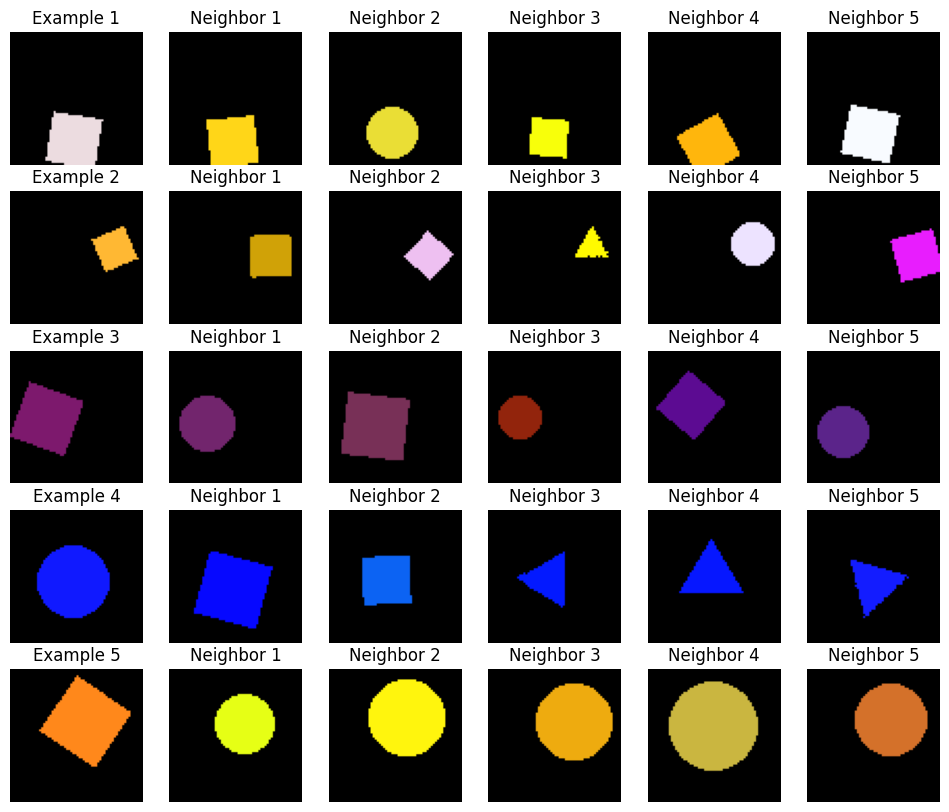

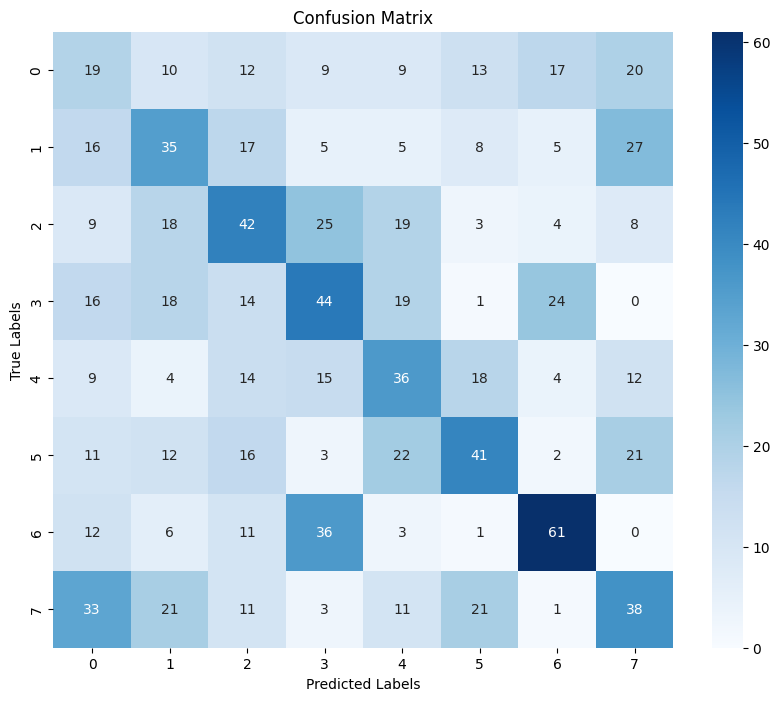

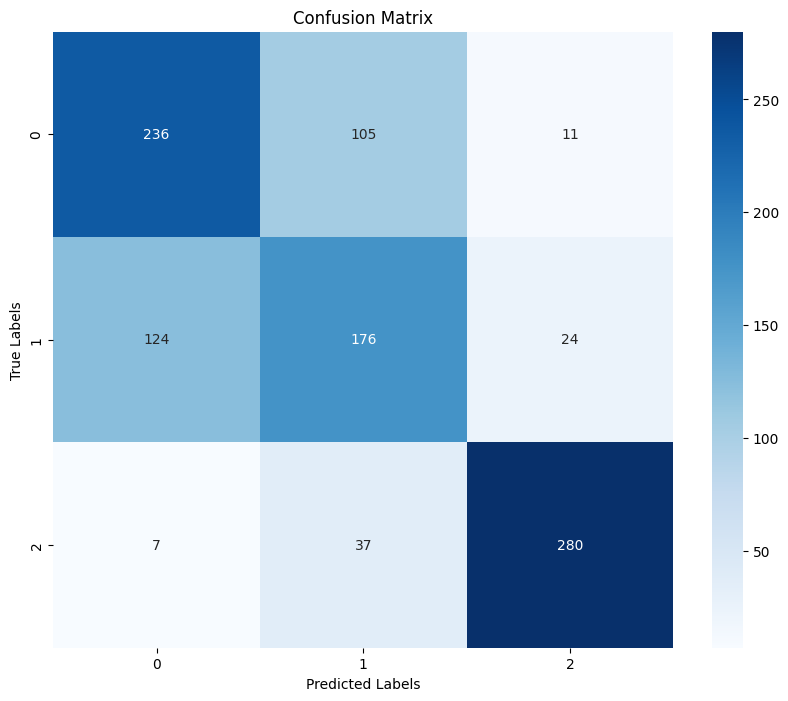

Silhouette Score: -0.18267805874347687
Cluster Purity: 0.199
Normalized Mutual Information (NMI): 0.253383806744512


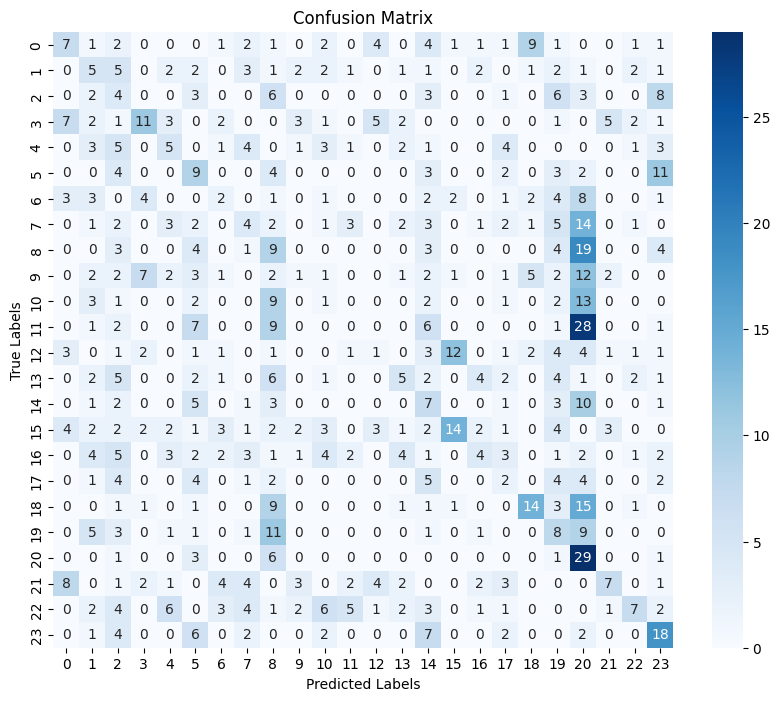

Silhouette Score: -0.11978046596050262
Cluster Purity: 0.253
Normalized Mutual Information (NMI): 0.09236148679114273


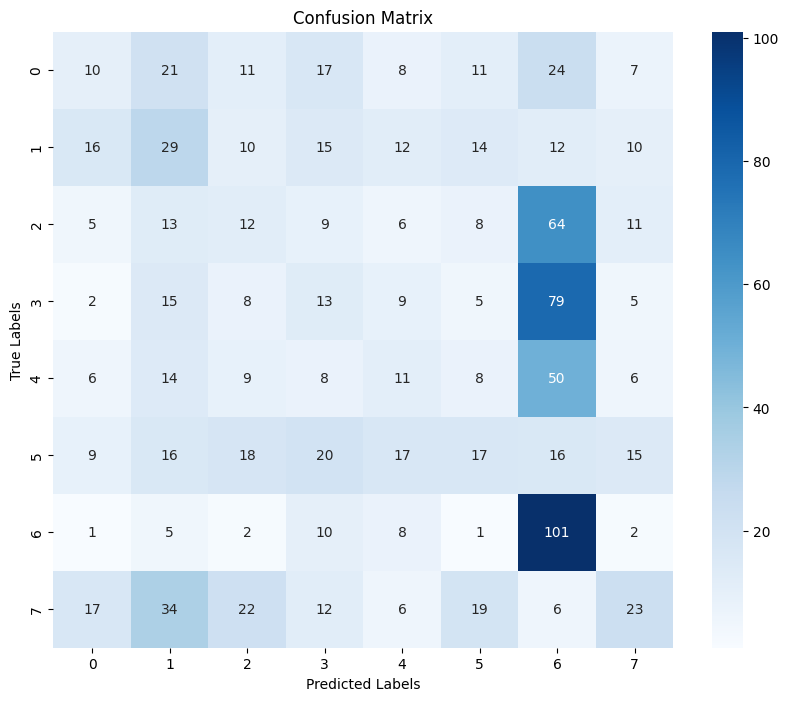

Silhouette Score: 0.012958349660038948
Cluster Purity: 0.475
Normalized Mutual Information (NMI): 0.13961660350911773


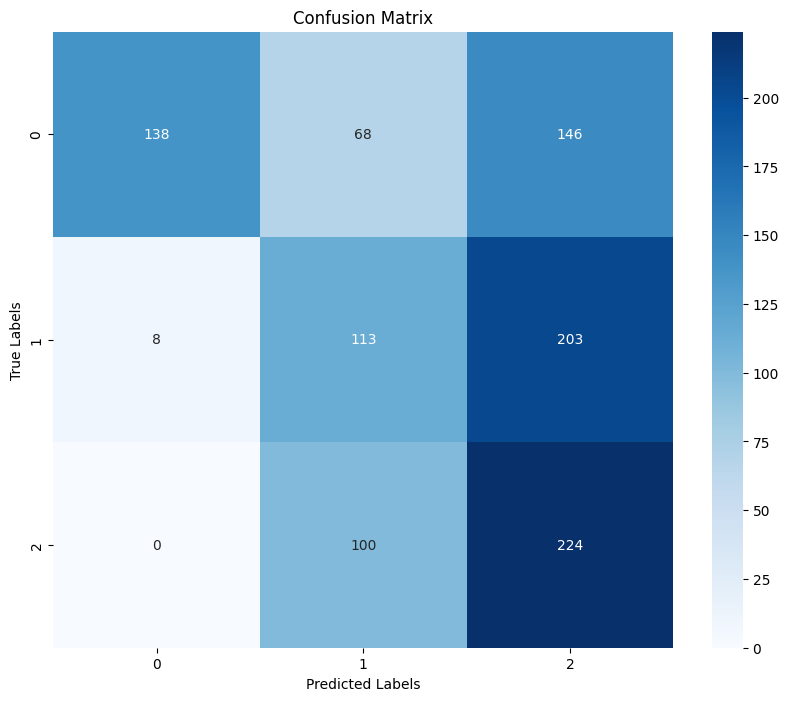

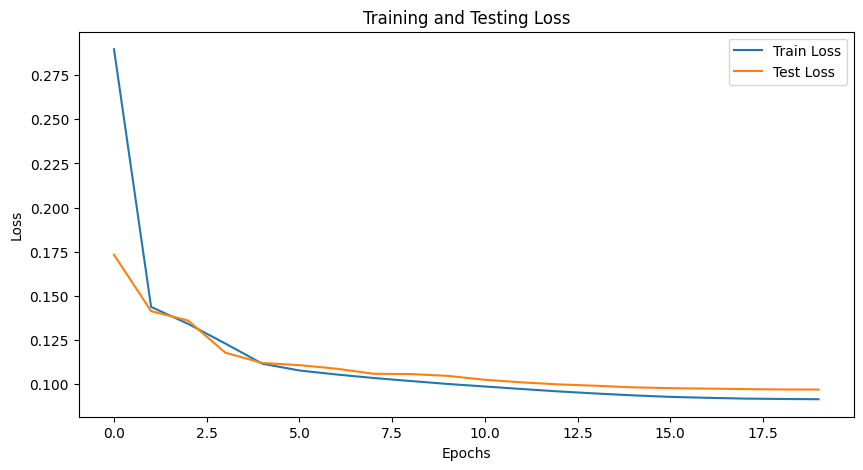

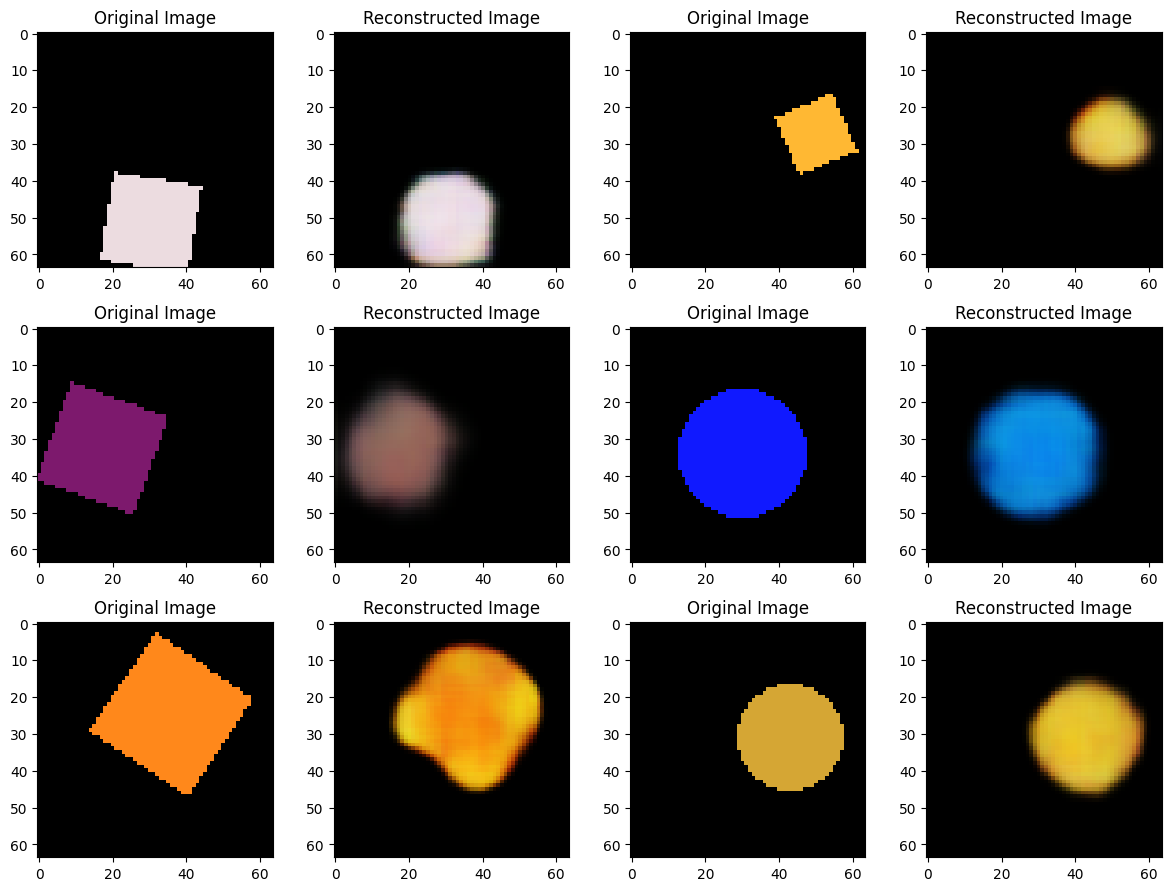

(Autoencoder(
   (encoder): Sequential(
     (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU()
     (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (4): ReLU()
     (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (7): ReLU()
     (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   )
   (fc1): Linear(in_features=8192, out_features=8, bias=True)
   (fc2): Linear(in_features=8, out_features=8192, bias=True)
   (decoder): Sequential(
     (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU()
     (2): Upsample(scale_factor=2.0, mode='nearest')
     (3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (4): ReLU()
     (5): Upsample(scale_fact

In [5]:
train_model(8)

Number of parameters: 604307


/Users/criyle/project/cse5524/cse5524final/util.py:333: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_embeddings = torch.tensor(train_embeddings)
/Users/criyle/project/cse5524/cse5524final/util.py:334: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_embeddings = torch.tensor(test_embeddings)


Color Accuracy: 0.311
Shape Accuracy: 0.71
Combined Accuracy: 0.222


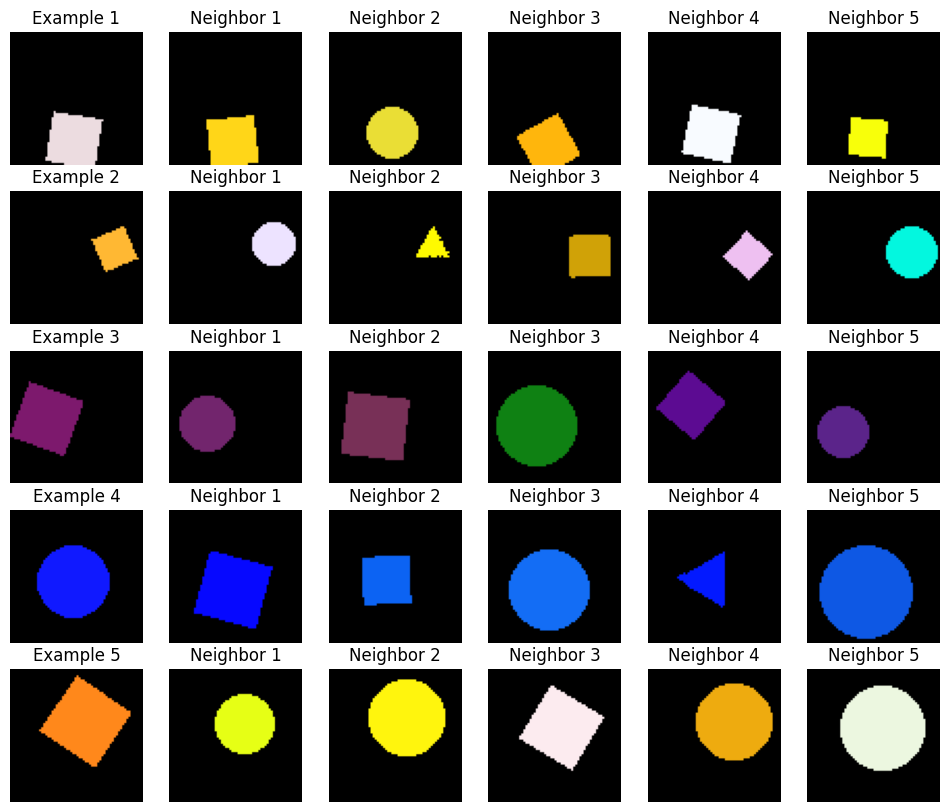

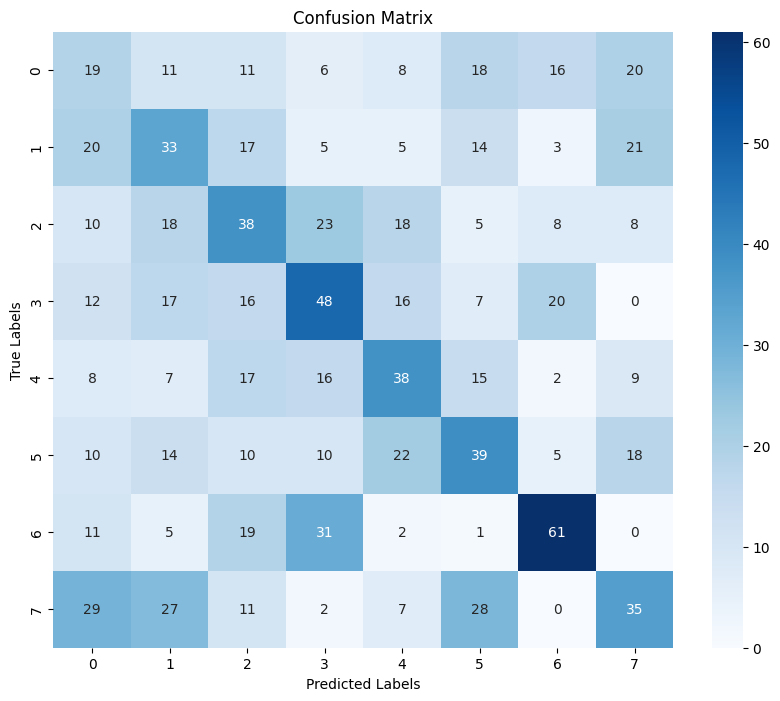

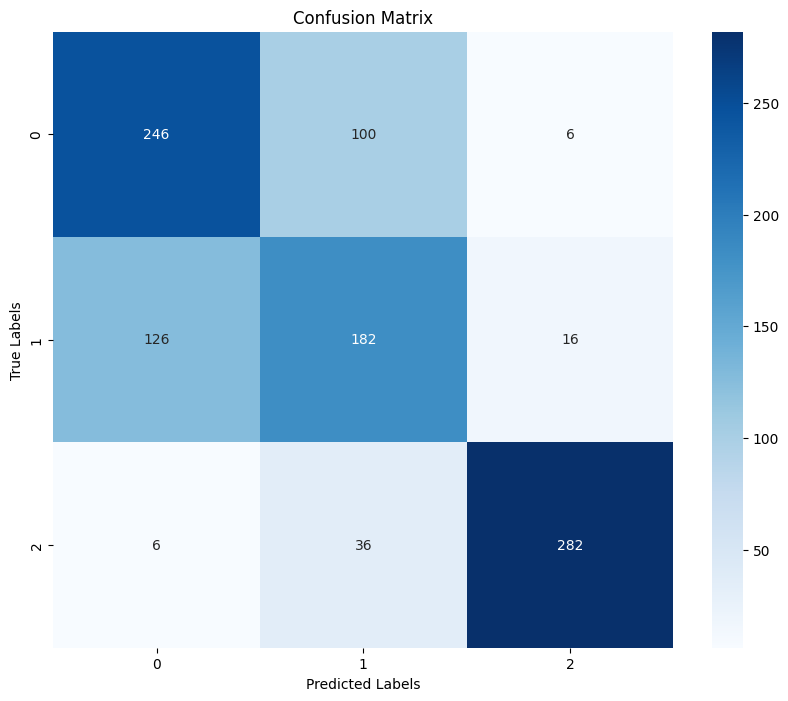

Silhouette Score: -0.1561737358570099
Cluster Purity: 0.186
Normalized Mutual Information (NMI): 0.2552362332937162


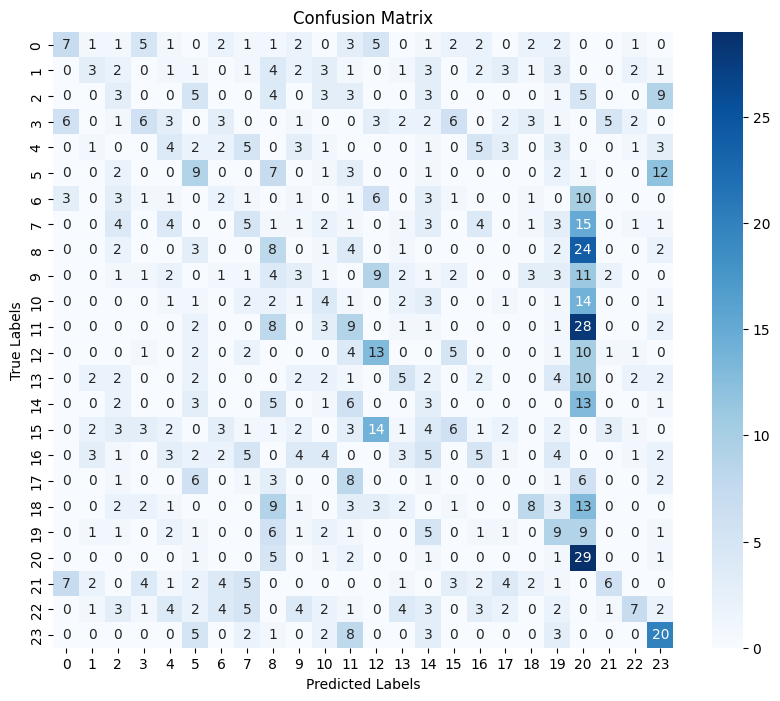

Silhouette Score: -0.09584339708089828
Cluster Purity: 0.23
Normalized Mutual Information (NMI): 0.07773840900324994


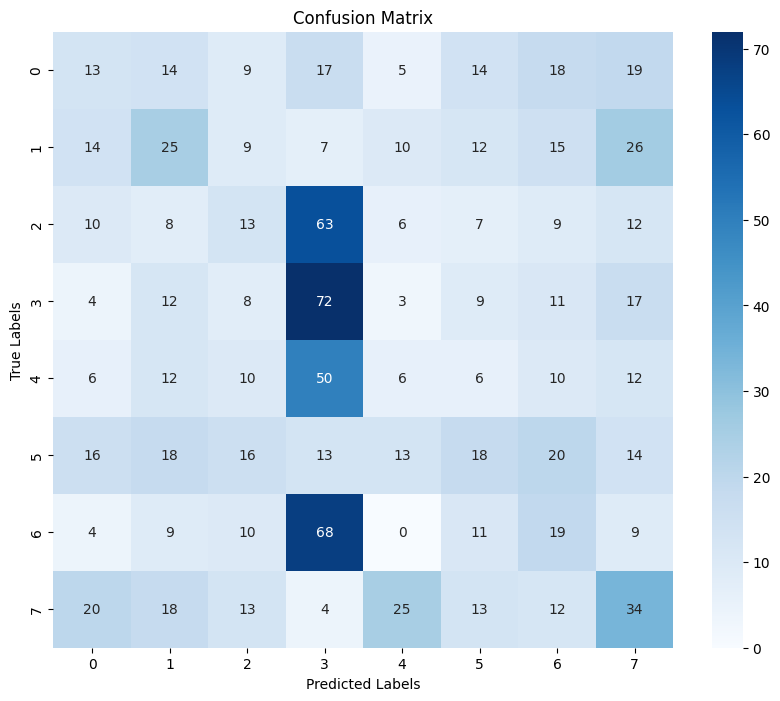

Silhouette Score: 0.019460003823041916
Cluster Purity: 0.482
Normalized Mutual Information (NMI): 0.14894350034165055


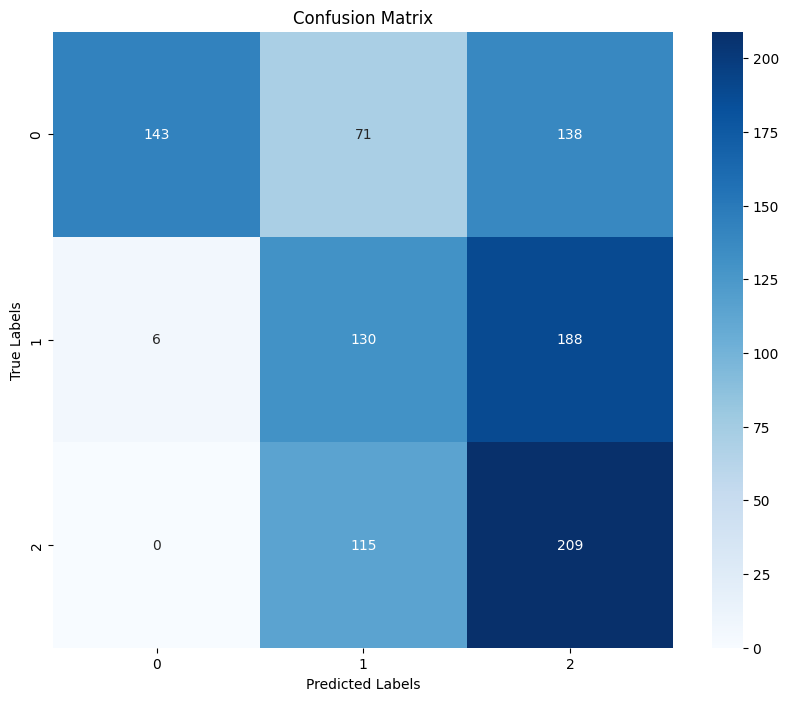

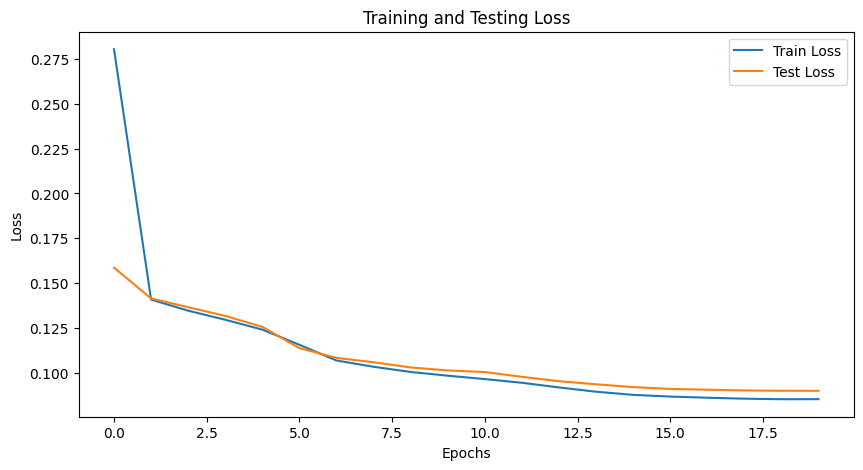

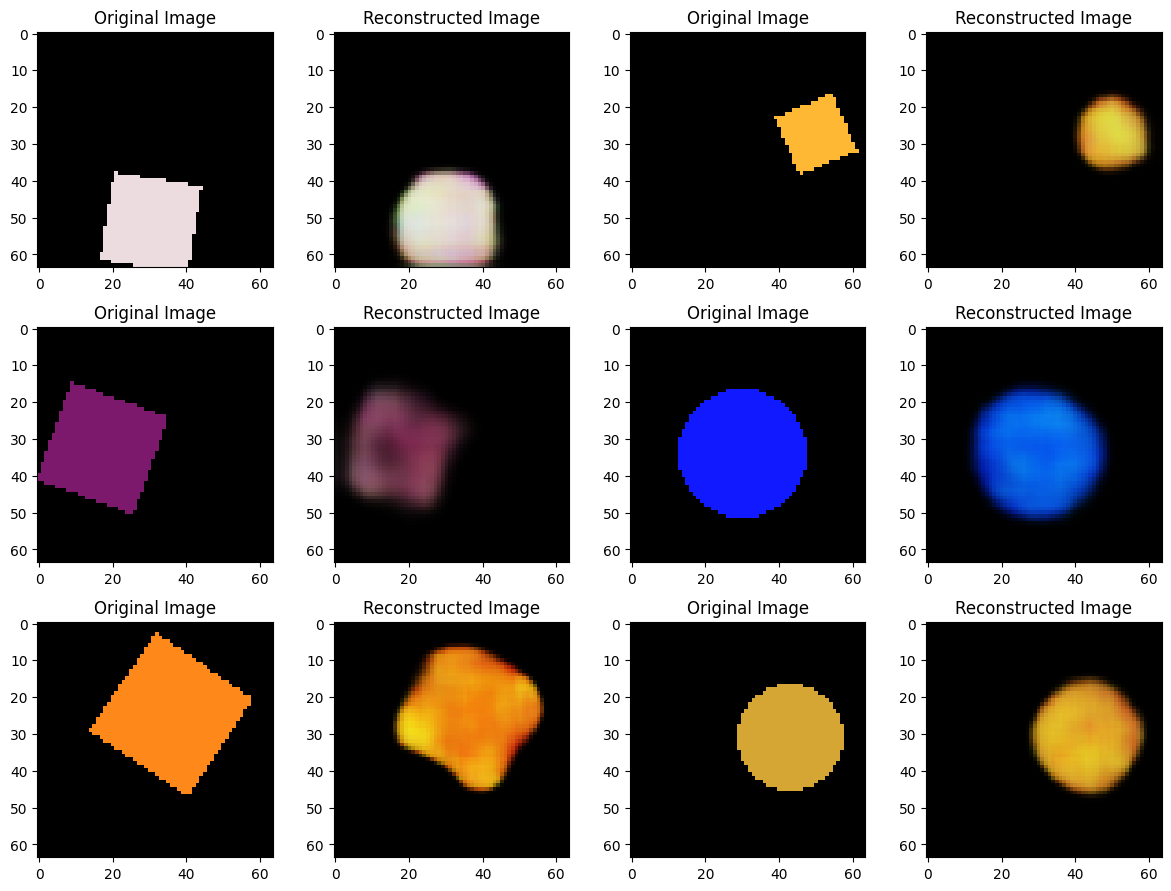

(Autoencoder(
   (encoder): Sequential(
     (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU()
     (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (4): ReLU()
     (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (7): ReLU()
     (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   )
   (fc1): Linear(in_features=8192, out_features=16, bias=True)
   (fc2): Linear(in_features=16, out_features=8192, bias=True)
   (decoder): Sequential(
     (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU()
     (2): Upsample(scale_factor=2.0, mode='nearest')
     (3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (4): ReLU()
     (5): Upsample(scale_fa

In [6]:
train_model(16)

Number of parameters: 866467


/Users/criyle/project/cse5524/cse5524final/util.py:333: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_embeddings = torch.tensor(train_embeddings)
/Users/criyle/project/cse5524/cse5524final/util.py:334: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_embeddings = torch.tensor(test_embeddings)


Color Accuracy: 0.319
Shape Accuracy: 0.732
Combined Accuracy: 0.227


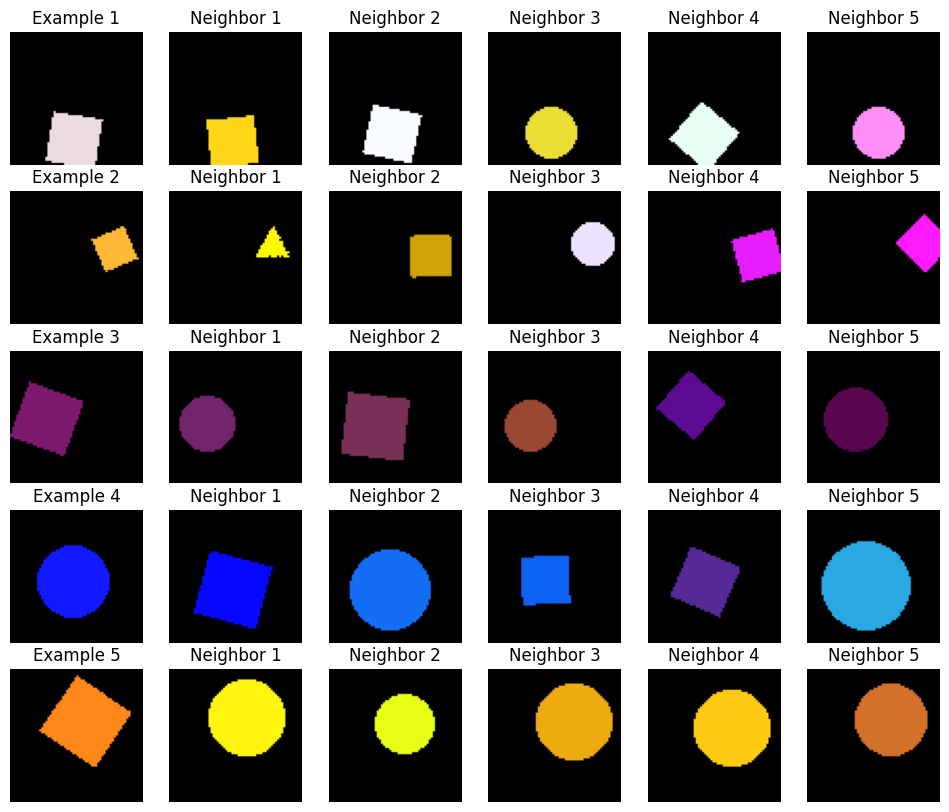

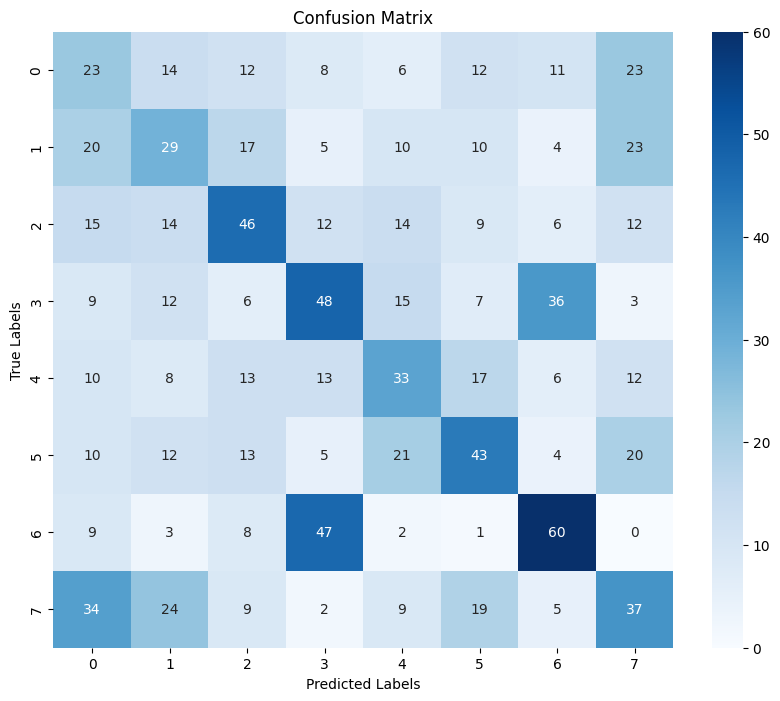

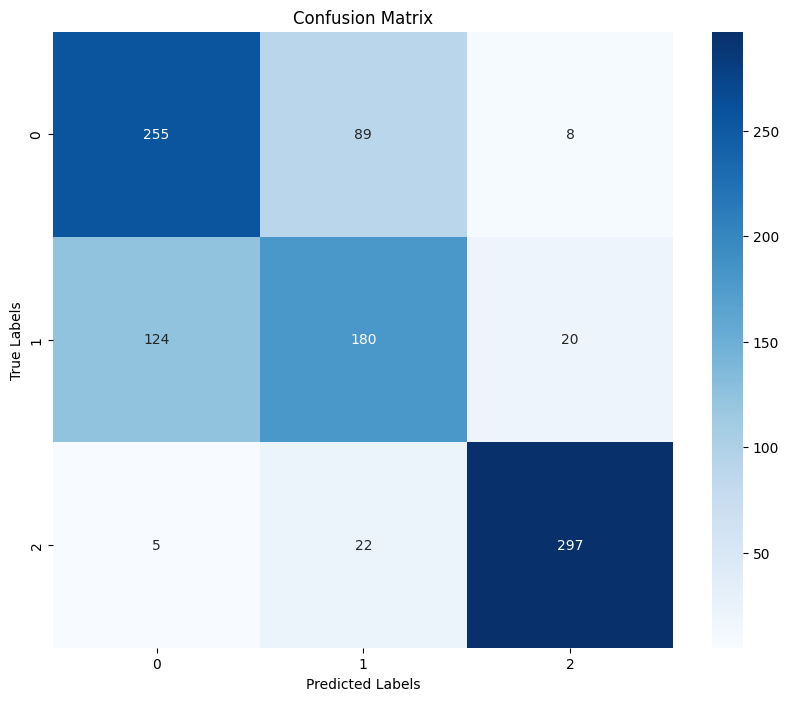

Silhouette Score: -0.1475677341222763
Cluster Purity: 0.206
Normalized Mutual Information (NMI): 0.25326838608211144


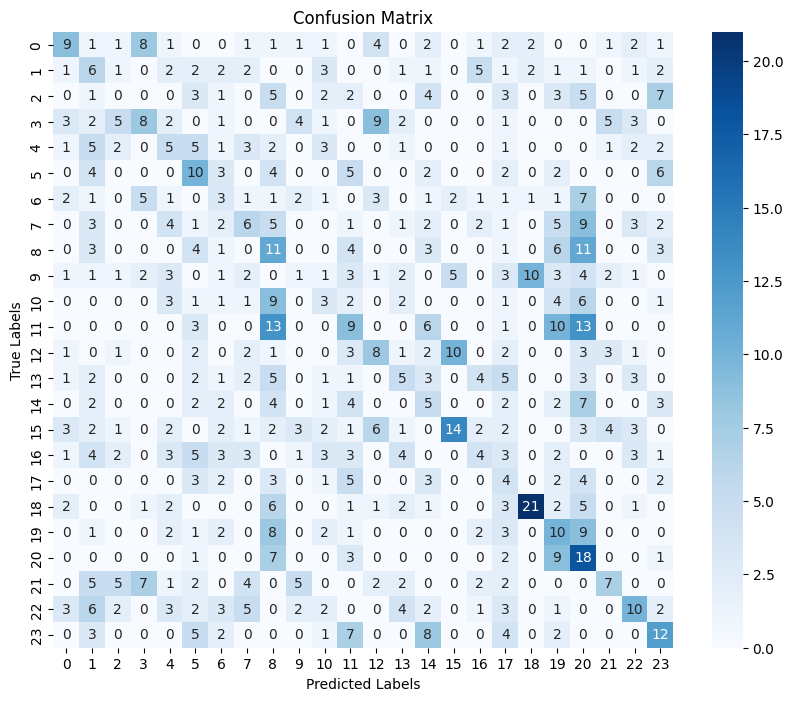

Silhouette Score: -0.10905430465936661
Cluster Purity: 0.227
Normalized Mutual Information (NMI): 0.07175704306801582


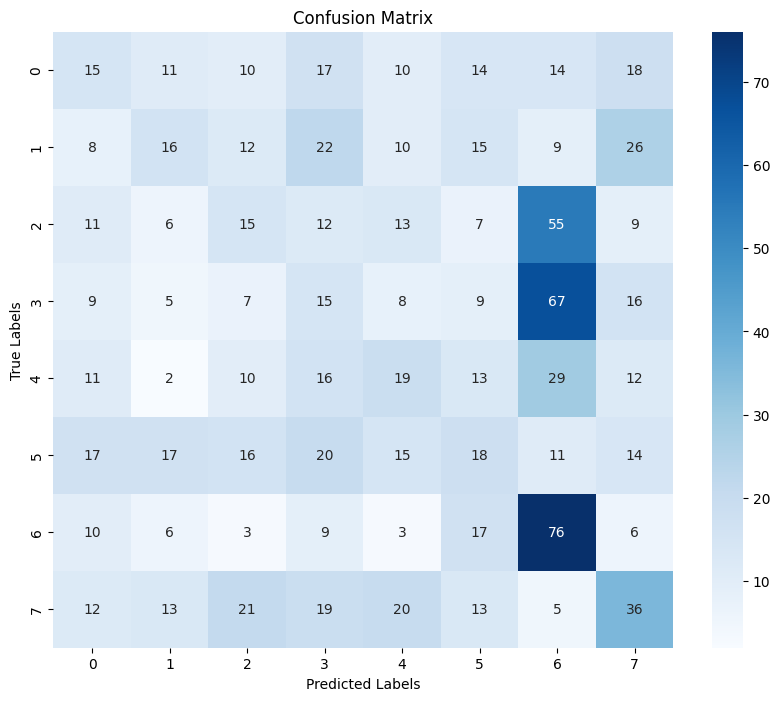

Silhouette Score: 0.021131671965122223
Cluster Purity: 0.502
Normalized Mutual Information (NMI): 0.17247612665706594


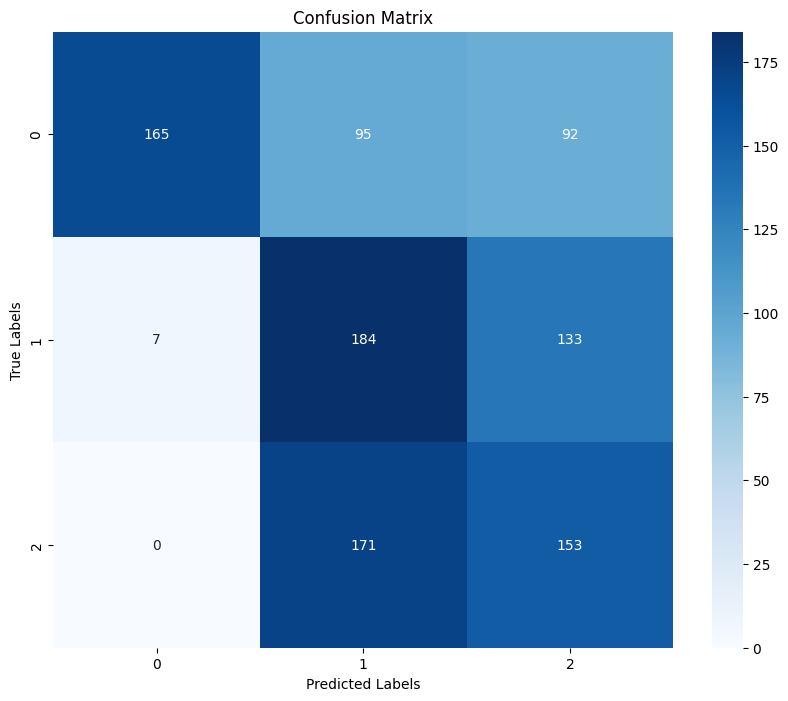

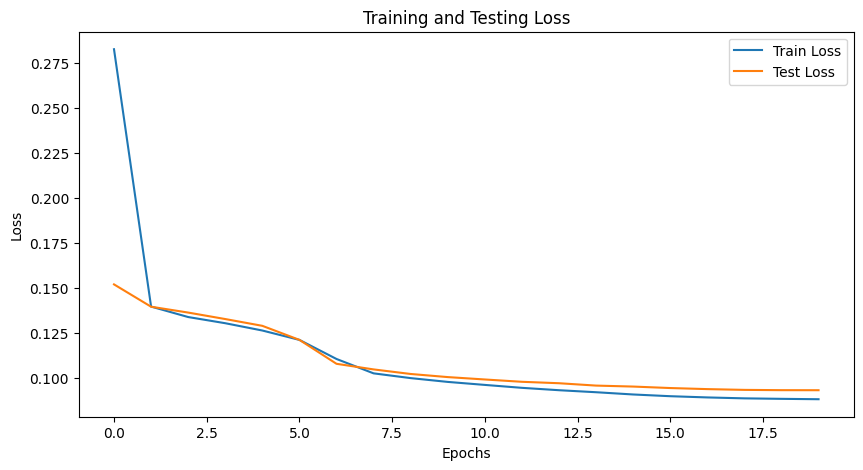

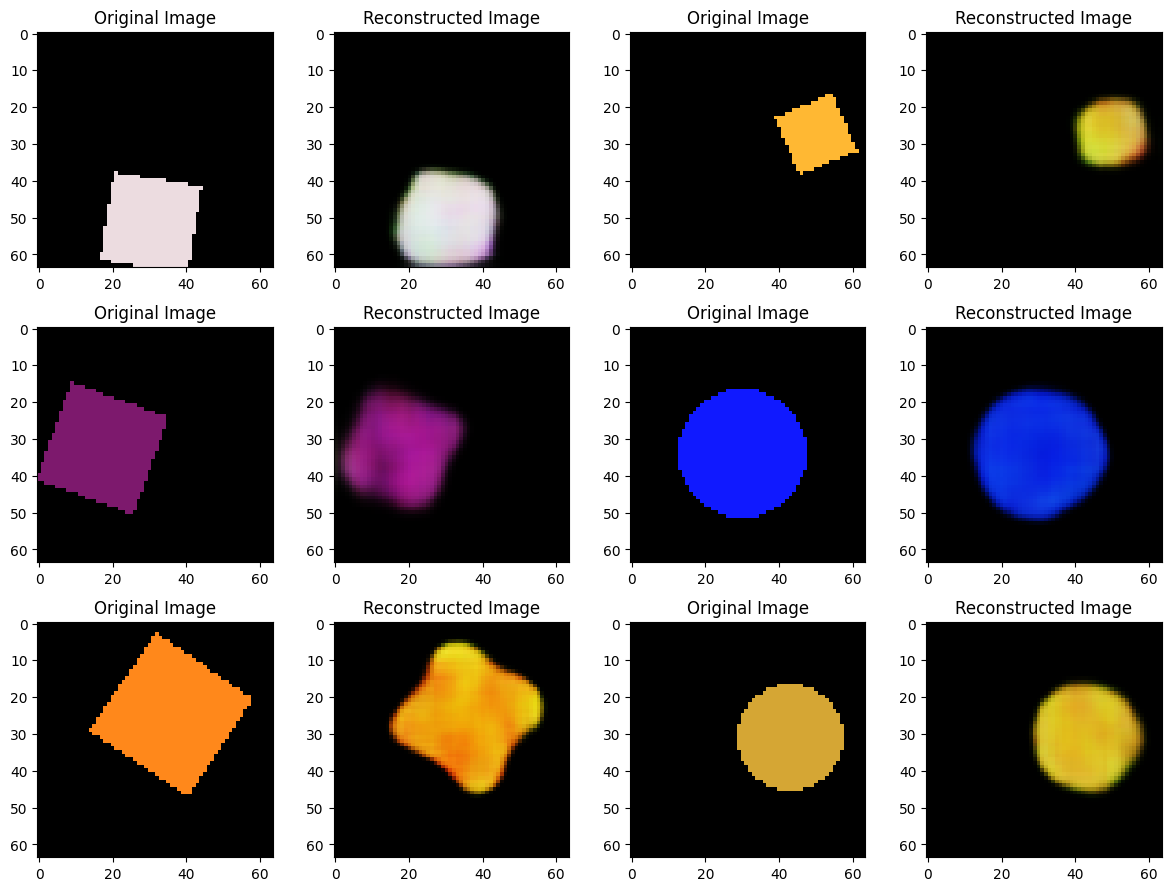

(Autoencoder(
   (encoder): Sequential(
     (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU()
     (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (4): ReLU()
     (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (7): ReLU()
     (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   )
   (fc1): Linear(in_features=8192, out_features=32, bias=True)
   (fc2): Linear(in_features=32, out_features=8192, bias=True)
   (decoder): Sequential(
     (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU()
     (2): Upsample(scale_factor=2.0, mode='nearest')
     (3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (4): ReLU()
     (5): Upsample(scale_fa

In [7]:
train_model(32)

Number of parameters: 1390787


/Users/criyle/project/cse5524/cse5524final/util.py:333: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_embeddings = torch.tensor(train_embeddings)
/Users/criyle/project/cse5524/cse5524final/util.py:334: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_embeddings = torch.tensor(test_embeddings)


Color Accuracy: 0.305
Shape Accuracy: 0.738
Combined Accuracy: 0.218


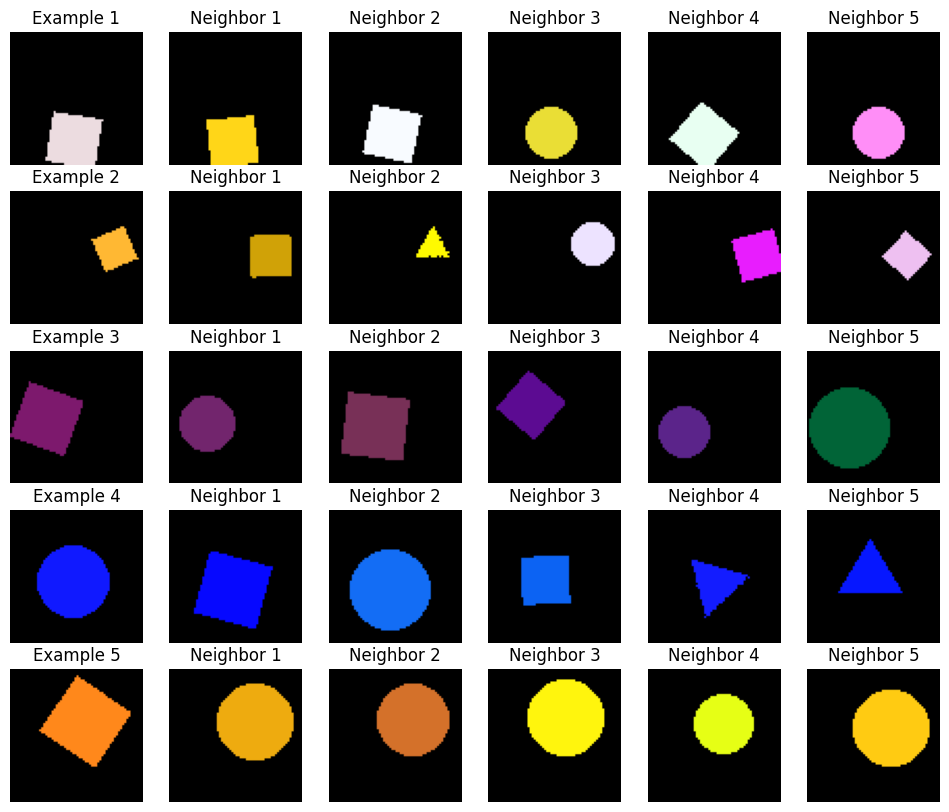

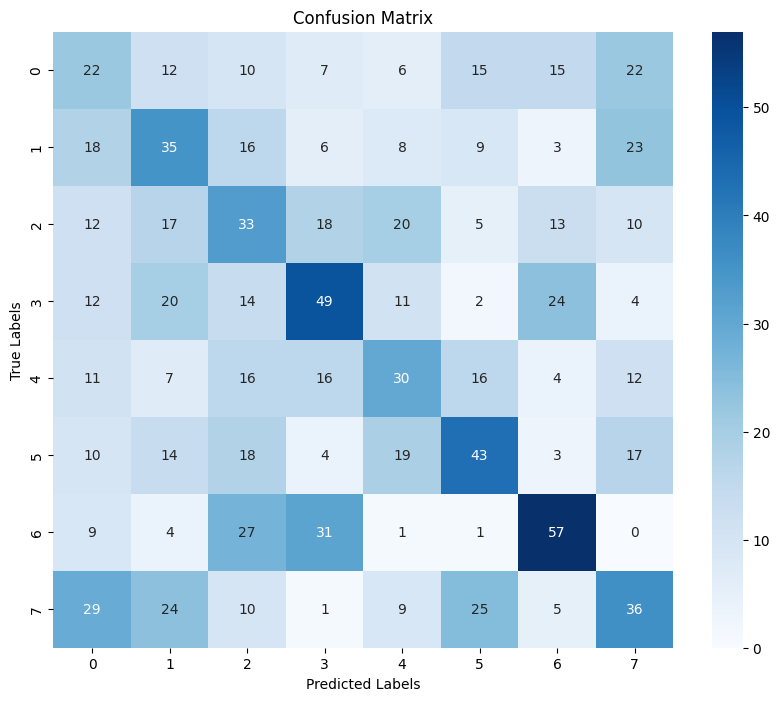

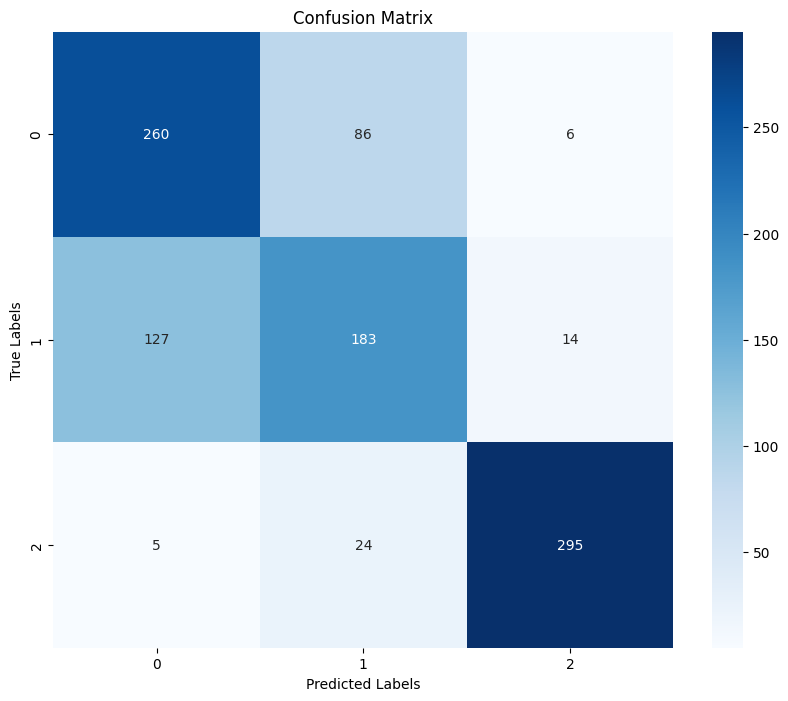

Silhouette Score: -0.15369820594787598
Cluster Purity: 0.211
Normalized Mutual Information (NMI): 0.2612415049483808


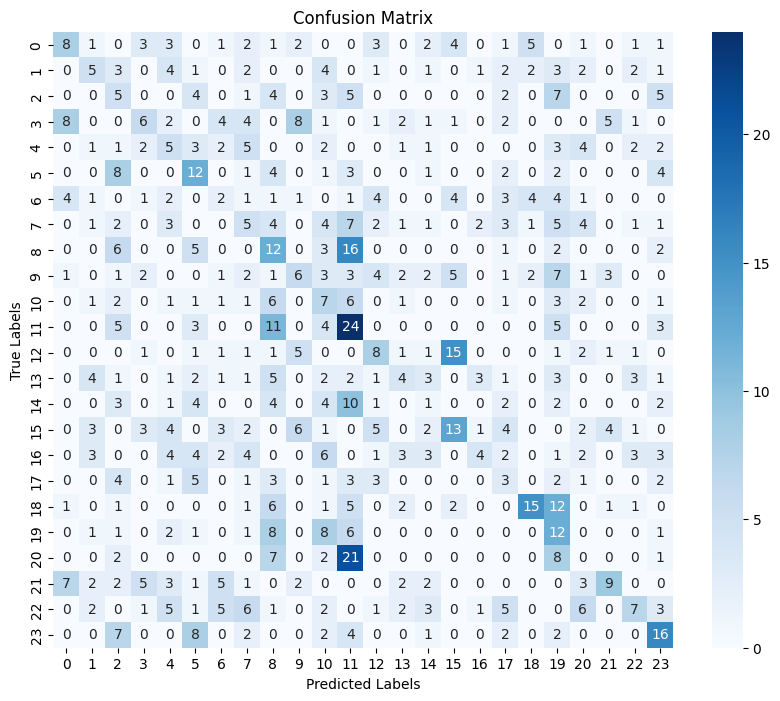

Silhouette Score: -0.11303441226482391
Cluster Purity: 0.259
Normalized Mutual Information (NMI): 0.0934858360764445


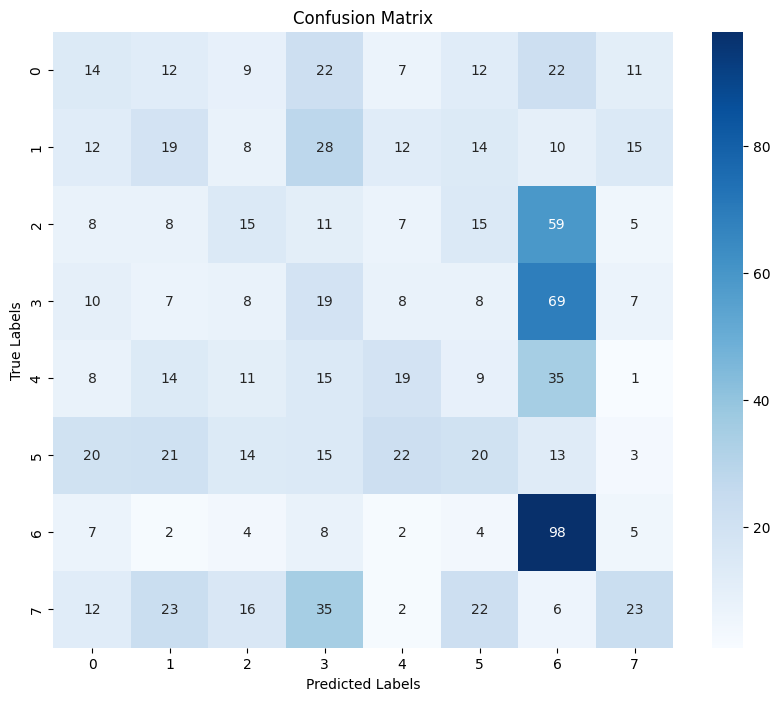

Silhouette Score: 0.022604167461395264
Cluster Purity: 0.485
Normalized Mutual Information (NMI): 0.15918234495542408


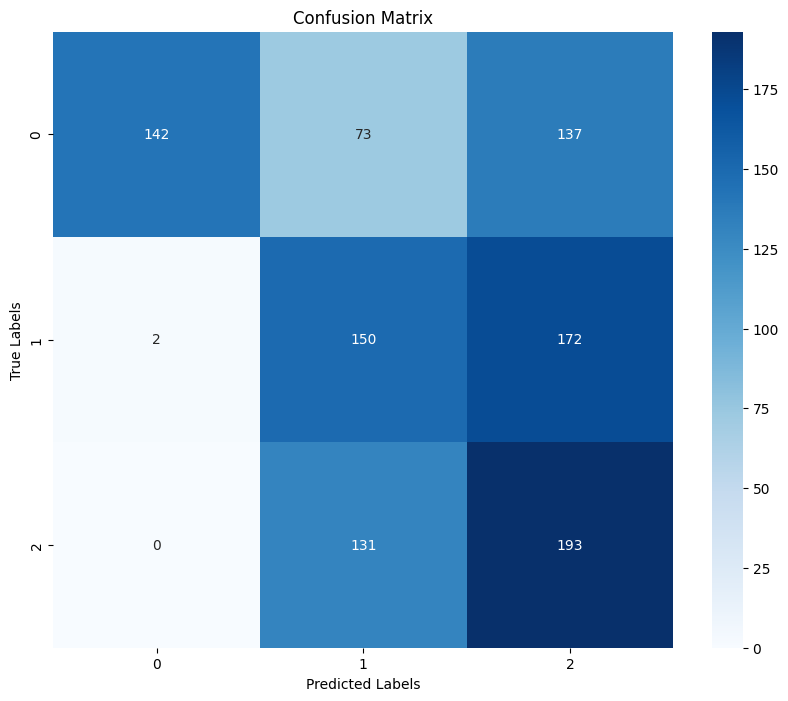

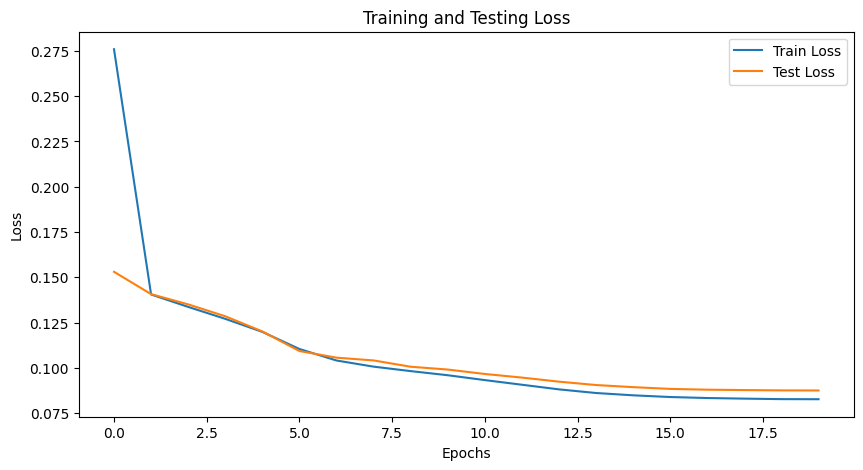

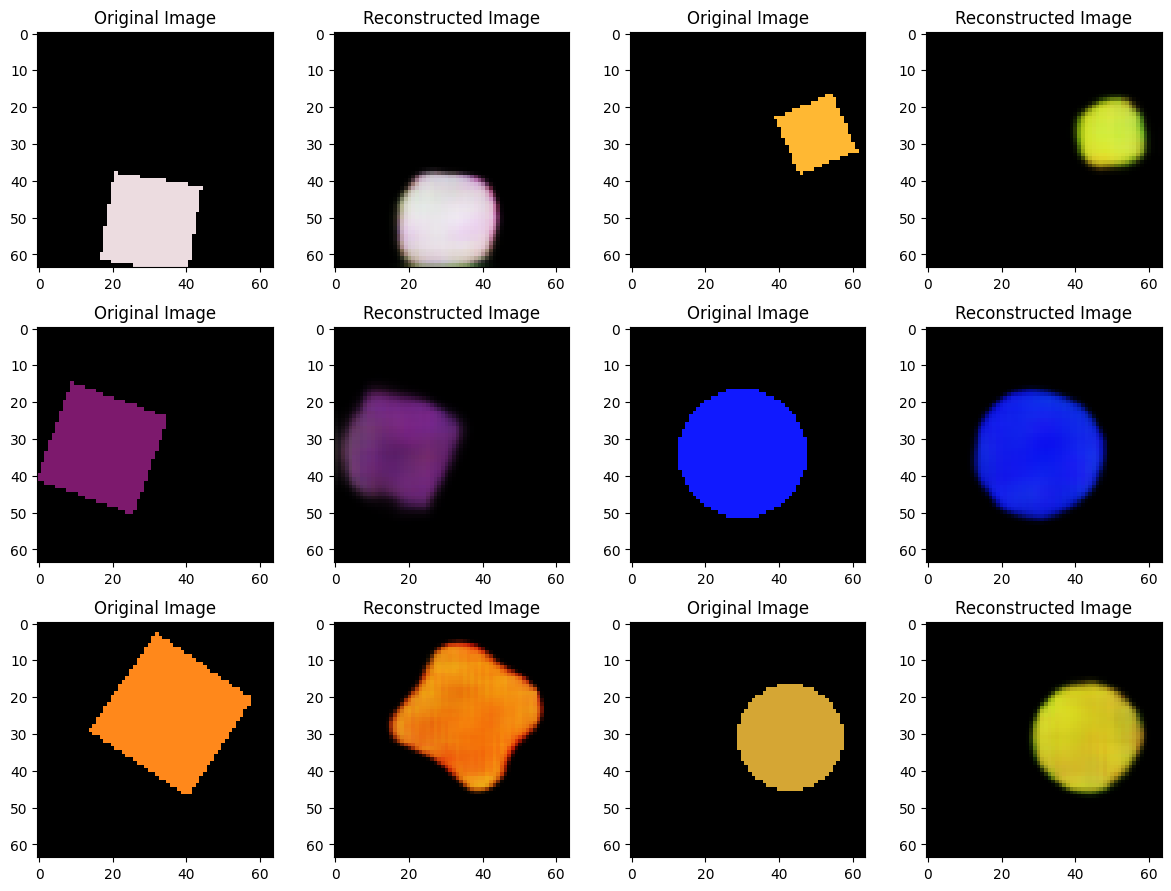

(Autoencoder(
   (encoder): Sequential(
     (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU()
     (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (4): ReLU()
     (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (7): ReLU()
     (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   )
   (fc1): Linear(in_features=8192, out_features=64, bias=True)
   (fc2): Linear(in_features=64, out_features=8192, bias=True)
   (decoder): Sequential(
     (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU()
     (2): Upsample(scale_factor=2.0, mode='nearest')
     (3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (4): ReLU()
     (5): Upsample(scale_fa

In [8]:
train_model(64)

## Plot

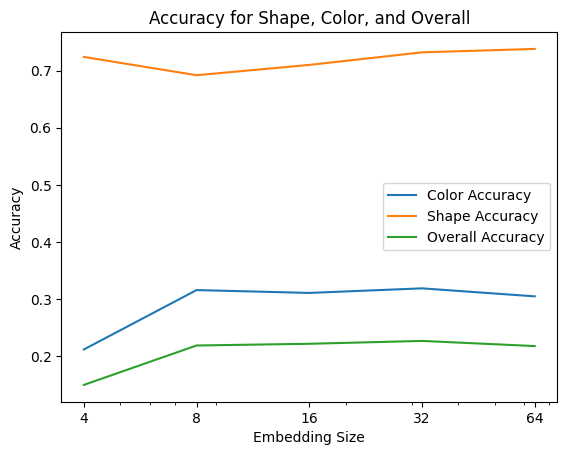

{4: (212, 724, 150), 8: (316, 692, 219), 16: (311, 710, 222), 32: (319, 732, 227), 64: (305, 738, 218)}


In [10]:
x = list(accuracy.keys())
color_acc = [x[0] / 1000 for x in accuracy.values()]
shape_acc = [x[1] / 1000 for x in accuracy.values()]
all_acc = [x[2] / 1000 for x in accuracy.values()]

import matplotlib.pyplot as plt

# Plotting the values
plt.plot(x, color_acc, label='Color Accuracy')
plt.plot(x, shape_acc, label='Shape Accuracy')
plt.plot(x, all_acc, label='Overall Accuracy')

# Adding labels and title
plt.xlabel('Embedding Size')
plt.ylabel('Accuracy')
plt.xscale('log')
plt.xticks(x, x)
plt.title('Accuracy for Shape, Color, and Overall')

# Adding legend
plt.legend()

# Display the plot
plt.show()

print(accuracy)
